# Histopathologic Cancer Detection
## Source
This project is a Kaggle competition that can be found here https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview
## Project Overview
The goal of this project is to identify metastatic cancer in small image patches taken from larger digital pathology scans.  According to Kaggle, the dataset is a slightly modified version of the PatchCamelyon benchmark dataset.  There are over 220,000 training images and over 50,000 test images.  All of the images are fairly small (96x96) and contained in the Kaggle competition's input folders.  Correct labels for the training images have been provided in a comma-separated values (.csv) file. 

## Import Libraries

In [2]:
# Load lots of libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL.Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from keras.metrics import AUC
print("Tensorflow version:", tf.__version__)

2024-04-01 22:42:00.076046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 22:42:00.076186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 22:42:00.230640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version: 2.15.0


In [3]:
# Create a function that will prefix the correct Kaggle input folder to each image ID
def generate_file_names(id):
    return f"../input/histopathologic-cancer-detection/train/{id}.tif"

In [4]:
# Load the training data and labels.  Get information about the files in the directories.
core_path = '/kaggle/input/histopathologic-cancer-detection/'
test_path = core_path + 'test/'
train_path = core_path + 'train/'
df_train = pd.read_csv(core_path + "train_labels.csv")
df_test = pd.read_csv(core_path + "sample_submission.csv")
print("Training data frame:\n", df_train.head())
num_train_images = len(df_train)
num_train_image_files = len(os.listdir(train_path))
num_test_images = len(os.listdir(test_path))
print("Number training images:", num_train_images)
print("Number training image files:", num_train_image_files)
print("Number test images:    ", num_test_images)

# Get a list of all of the names of the files in the directories
train_images_dir_filenames = os.listdir(train_path)
test_images_dir_filenames = os.listdir(test_path)
print("A sample of the training images filenames in the directory:\n", train_images_dir_filenames[:4])
print("A sample of the test images filenames in the directory:\n", test_images_dir_filenames[:4])

# Convert the labels to type string for later use by ImageDataGenerator
df_train["label"] = df_train["label"].astype(str)
# Save off the complete path and filename for each ID as a new column
df_train["filename"] = df_train["id"].apply(generate_file_names)

Training data frame:
                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Number training images: 220025
Number training image files: 220025
Number test images:     57458
A sample of the training images filenames in the directory:
 ['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif']
A sample of the test images filenames in the directory:
 ['a7ea26360815d8492433b14cd8318607bcf99d9e.tif', '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif', '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif', 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif']


## Basic Exploratory Data Analysis
The data provided by the Kaggle competition has already been cleaned, so there isn't much work requried.  There are no missing values (IDs, labels) in the training set.  All of the labels are either 0 or 1.  There are over 220,000 training images of which about 40% are tumor positive.

Number of empty cells: 0
All possible values for training labels: {'1', '0'}
label
0    130908
1     89117
Name: count, dtype: int64
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64
Number of training images that are tumor postive: 0
Number of training images that are tumor negative: 220025


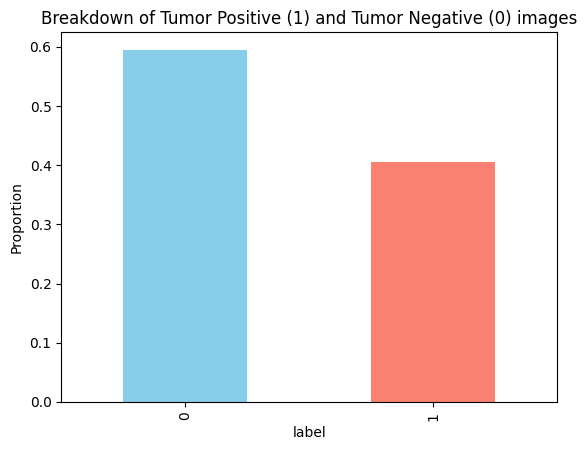

In [5]:
# Check if there are any missing values (IDs or labels)
numNaNs = df_train.isna().sum().sum()  # Count the total number of NaNs across all columns
print("Number of empty cells:", numNaNs)

print("All possible values for training labels:", set(df_train['label']))
print(df_train['label'].value_counts())
print(df_train['label'].value_counts(normalize=True))
#df_train_labels['label'].plot(kind='hist', density=True)
df_train['label'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Breakdown of Tumor Positive (1) and Tumor Negative (0) images')
plt.ylabel('Proportion')
num_train_is_tumor = len(df_train[df_train['label'] == 1])
print("Number of training images that are tumor postive:", num_train_is_tumor)
print("Number of training images that are tumor negative:", num_train_images-num_train_is_tumor)

## View single image
The following is an example of one of the many images that have been provided.  Note that the images are 96x96 pixels and 3-channel (RGB).

Image Shape = (96, 96, 3)
87832    0
Name: label, dtype: object


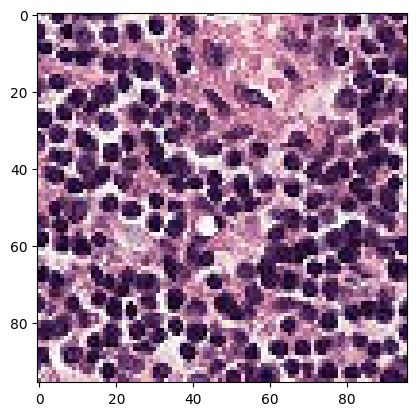

In [6]:
# Display a single image and its properties
singleImage_path = "/kaggle/input/histopathologic-cancer-detection/train/00004aab08381d25d315384d646f5ce413ea24b1.tif"
singleImage = PIL.Image.open(singleImage_path)
singleImage_array = np.array(singleImage)
print(f"Image Shape = {singleImage_array.shape}")
print(df_train[df_train['id'] == '00004aab08381d25d315384d646f5ce413ea24b1']['label'])
plt.imshow(singleImage)
plt.show()

## Grid of tumor positive and tumor negative images
The following graphics shows three images that are tumor positive, and three that are tumor negative. It's hard to see any difference among them with the human eye.

Image mode: RGB


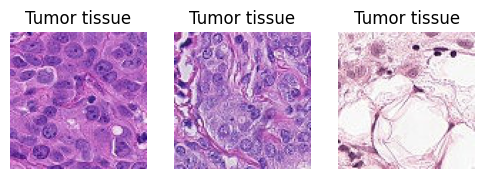

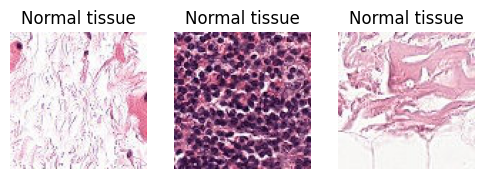

In [7]:
# Sort the training data according to the ID so that it is in the same order as the files in the 
#   training directory.
#df_train_labels.sort_values(by='id', inplace=True)
# Display some of the images - three each of the tumor positive and negative
numToDisplay = 3
sample_tumorPos_ids = df_train[df_train['label'] == '1']['id'].sample(n=numToDisplay).values
sample_tumorNeg_ids = df_train[df_train['label'] == '0']['id'].sample(n=numToDisplay).values

tumorPos_images = []
for id in sample_tumorPos_ids:
    image_path = os.path.join(train_path, id + '.tif')  
    tumorPos_images.append(PIL.Image.open(image_path))
    
tumorNeg_images = []
for id in sample_tumorNeg_ids:
    image_path = os.path.join(train_path, id + '.tif') 
    tumorNeg_images.append(PIL.Image.open(image_path))

print("Image mode:", tumorPos_images[1].mode)
plt.figure(figsize=(6, 3))
for i, image in enumerate(tumorPos_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Tumor tissue')
    plt.axis('off')
plt.show()

plt.figure(figsize=(6, 3))
for i, image in enumerate(tumorNeg_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Normal tissue')
    plt.axis('off')
plt.show()

# Analysis Strategy and Data Preparation
## Strategy
Based on the structure of the input data, the strategy for classification is to split the training data into a training and validation set.  Then create a few convolution network models to train on the training data and validate with the validation data.  Once a reasonable model is achieved, it will be used to predict the labels for the test data.

## Create Sample of Training Data
Since there are over 220,000 images in the training set, a random sample will be generated and used in the model training.  To ensure that the balance between tumor positive and tumor negative labels is maintained, a set of 10 samples of 22,000 images is generated and the label proportion compared to the 40% in the full set.  The result is that each of the samples is very close to 40%, just like the full data set.

The training and evaluation was done iteratively with 10%, 20%, 30%, and 100% of the total training data.

All of the images were normalized using the rescale of the ImageDataGenerator.

In [9]:
# Create randomized samples from the full training data set.
sampleFrac = 0.3
sampleLen = len(df_train) * sampleFrac

props = np.zeros(10)
for i in range(10):
    df_train_sample_0 = df_train.sample(frac = sampleFrac, replace = False)
    props[i] = df_train_sample_0[(df_train_sample_0['label'] == '1')].shape[0] / sampleLen
print(props)

df_train_sample = df_train.sample(frac = sampleFrac, replace = False)

[0.40592357 0.4071204  0.40518123 0.40342385 0.40519638 0.40402985
 0.40698405 0.40484793 0.40509033 0.40469644]


In [12]:
# Perform normalization on the images using the rescale capability of ImageDataGenerator
# Create a train / validation split of the training data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [13]:
# Allow for use of the full data set (here) or a random sample (next cell below)
useFullDF = False
if useFullDF == True:
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="filename",
        y_col="label",
        target_size=(96, 96),
        color_mode="rgb",
        batch_size=16,
        class_mode="binary",
        subset="training"
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="filename",
        y_col="label",
        target_size=(96, 96),
        color_mode="rgb",
        batch_size=16,
        class_mode="binary",
        subset="validation"
    )

In [15]:
useDfSample = True
if useDfSample == True:
    train_gen_sample = datagen.flow_from_dataframe(
        dataframe=df_train_sample,
        x_col="filename",
        y_col="label",
        target_size=(96, 96),
        color_mode="rgb",
        batch_size=16,
        class_mode="binary",
        subset="training"
    )

    validation_gen_sample = datagen.flow_from_dataframe(
        dataframe=df_train_sample,
        x_col="filename",
        y_col="label",
        target_size=(96, 96),
        color_mode="rgb",
        batch_size=16,
        class_mode="binary",
        subset="validation"
    )

Found 52807 validated image filenames belonging to 2 classes.
Found 13201 validated image filenames belonging to 2 classes.


In [16]:
# Turn the test images into a data generator
createTestGen = True
if createTestGen == True:
    test_path = "../input/histopathologic-cancer-detection/test"
    test_ids = [filename[:-4] for filename in os.listdir(test_path)]
    test_filepath = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
    test_df = pd.DataFrame()
    test_df["id"] = test_ids
    test_df["filepath"] = test_filepath

    test_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="filepath",
        y_col=None,
        target_size=(96, 96),
        color_mode="rgb",
        batch_size=16,
        shuffle=False,
        class_mode=None
    )

Found 57458 validated image filenames.


In [40]:
# Helper function that will be used to plot the validation loss, accuracy, and AUC for each trained model.
def plot_history(history):

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(1, len(history["loss"]) + 1), history["loss"], label="train")
    plt.plot(np.arange(1, len(history["val_loss"]) + 1), history["val_loss"], label="validation")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(1, len(history["accuracy"]) + 1), history["accuracy"], label="train")
    plt.plot(np.arange(1, len(history["val_accuracy"]) + 1), history["val_accuracy"], label="validation")
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(np.arange(1, len(history["AUC"]) + 1), history["AUC"], label="train")
    plt.plot(np.arange(1, len(history["val_AUC"]) + 1), history["val_AUC"], label="validation")
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
# Generate the predictions for the test set defined by "test_generator" and write them to a .csv file
def generate_output_csv_file(model, test_generator, filename):
    test_probs = model.predict(test_generator)
    test_labels = np.round(test_probs).astype(int).flatten()
    out_df = pd.DataFrame({"id": test_ids, "label": test_labels})
    out_df.to_csv(os.path.join("/kaggle/working/", filename), index=False)

In [37]:
# Determine which epoch had the best performance based on the validation loss metric
# Once determined, return the epoch number, validation loss, validation accuracy, and val AUC
# The input history is from a model fitting process
def get_best_metrics(history):
    # Fit history keys ['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])
    minIndex = np.argmin(history["val_loss"])
    best_epoch = minIndex + 1
    best_loss = history['val_loss'][minIndex]
    best_accuracy = history['val_accuracy'][minIndex]
    best_auc = history['val_AUC'][minIndex]
    return best_epoch, best_loss, best_accuracy, best_auc

# Model Architecture
A series of increasingly complex models were built and tested.  The first model has just two convolutional layers with a max pooling and flattening, followed by three fully connected layers.

The second model followed the recipe of using multiple blocks of convolutional layers followed by a batch normalization and max pooling.  This second model has three of these blocks followed by two fully connected layers along with a dropout layer.

The final model has three blocks plus four fully connected layers.

All of the max pooling layers are 2x2.

In [60]:
def finalize_model(model, LR):
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
                  metrics=['accuracy', 'AUC'])
    model.summary()
    return model

In [61]:
def create_basic_conv_model(modelName='', LR = 0.001):
    if modelName != '':
        model = Sequential(modelName)
    else:
        model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return finalize_model(model, LR)

In [58]:
def create_intermediate_conv_model(LR = 0.0005):
    model = Sequential()
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification    
    return finalize_model(model, LR)

In [71]:
def create_advanced_conv_model(LR = 0.0005):
    model = Sequential()
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification    
    return finalize_model(model, LR)

In [24]:
def train_model(model, train_gen, validation_gen, test_gen, numEpochs = 6):
    np.random.seed(0)
    tf.random.set_seed(0)
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

    history = model.fit(train_gen, validation_data=validation_gen,
                            epochs=numEpochs, callbacks=[early_stopping]).history
    return history

In [26]:
if useDfSample:
    train_gen, validation_gen = train_gen_sample, validation_gen_sample
else:
    train_gen, validation_gen = train_generator, validation_generator

In [29]:
# The first model uses a learning rate of 0.001
basicConvModel = create_basic_conv_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 135424)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    34,668,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,721,217 (132.45 MB)

 Trainable params: 34,721,217 (132.45 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
basicConvHistory = train_model(basicConvModel, train_gen, validation_gen, test_generator, numEpochs = 6)

Epoch 1/6


2024-04-01 20:34:07.211513: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8844: 6.01084, expected 5.28389
2024-04-01 20:34:07.211568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8864: 6.08888, expected 5.36192
2024-04-01 20:34:07.211583: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8883: 6.14659, expected 5.41964
2024-04-01 20:34:07.211603: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8896: 5.83716, expected 5.1102
2024-04-01 20:34:07.211622: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8897: 5.80389, expected 5.07694
2024-04-01 20:34:07.211636: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8898: 5.51694, expected 4.78999
2024-04-01 20:34:07.211646: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8899: 5.49689, expected 4.76994
2024-04-01 20:34:07.211656: E exter

   3/3301 ━━━━━━━━━━━━━━━━━━━━ 2:50 52ms/step - AUC: 0.6082 - accuracy: 0.6285 - loss: 2.4208 

I0000 00:00:1712003650.173983      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712003650.193178      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  54/3301 ━━━━━━━━━━━━━━━━━━━━ 4:29 83ms/step - AUC: 0.5508 - accuracy: 0.5553 - loss: 2.7365

2024-04-01 20:34:14.977658: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35344: 6.46895, expected 5.49298
2024-04-01 20:34:14.977718: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35345: 8.34787, expected 7.3719
2024-04-01 20:34:14.977728: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35346: 7.49972, expected 6.52376
2024-04-01 20:34:14.977736: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35347: 6.417, expected 5.44103
2024-04-01 20:34:14.977744: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35348: 7.06712, expected 6.09115
2024-04-01 20:34:14.977751: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35349: 7.74666, expected 6.77069
2024-04-01 20:34:14.977759: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 35351: 6.91453, expected 5.93856
2024-04-01 20:34:14.977766: E 

  59/3301 ━━━━━━━━━━━━━━━━━━━━ 6:13 115ms/step - AUC: 0.5523 - accuracy: 0.5557 - loss: 2.6511

W0000 00:00:1712003656.704624      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3298/3301 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - AUC: 0.7715 - accuracy: 0.7206 - loss: 0.6708

W0000 00:00:1712003958.206671      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-04-01 20:40:40.012124: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13181: 3.28429, expected 2.84901
2024-04-01 20:40:40.012198: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16470: 3.21095, expected 2.77566
2024-04-01 20:40:40.012213: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17736: 4.91057, expected 4.31149
2024-04-01 20:40:40.012222: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17922: 4.95471, expected 4.35562
2024-04-01 20:40:40.012230: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 17993: 4.56332, expected 3.96424
2024-04-01 20:40:40.012238: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18004: 4.88283, expected 4.28375
2024-04-01 20:40:40.012246: E external/lo

3301/3301 ━━━━━━━━━━━━━━━━━━━━ 397s 118ms/step - AUC: 0.7715 - accuracy: 0.7206 - loss: 0.6707 - val_AUC: 0.8565 - val_accuracy: 0.7816 - val_loss: 0.4772
Epoch 2/6
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 95s 29ms/step - AUC: 0.8478 - accuracy: 0.7820 - loss: 0.4768 - val_AUC: 0.8580 - val_accuracy: 0.7897 - val_loss: 0.4671
Epoch 3/6
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 95s 29ms/step - AUC: 0.8693 - accuracy: 0.7992 - loss: 0.4443 - val_AUC: 0.8623 - val_accuracy: 0.7952 - val_loss: 0.4555
Epoch 4/6
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 94s 28ms/step - AUC: 0.8891 - accuracy: 0.8190 - loss: 0.4087 - val_AUC: 0.8637 - val_accuracy: 0.7970 - val_loss: 0.4564
Epoch 5/6
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 97s 29ms/step - AUC: 0.9161 - accuracy: 0.8441 - loss: 0.3589 - val_AUC: 0.8609 - val_accuracy: 0.7932 - val_loss: 0.4792
Epoch 6/6
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 93s 28ms/step - AUC: 0.9411 - accuracy: 0.8733 - loss: 0.3031 - val_AUC: 0.8545 - val_accuracy: 0.7868 - val_loss: 0.5141
Epoch 6: early stopping


In [36]:
basicConvHistory.keys()

dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])

In [39]:
modelMetrics = get_best_metrics(basicConvHistory)
print(f"Best Epoch: {modelMetrics[0]}")
print(f"Best Model Loss: {modelMetrics[1]}")
print(f"Best Model Accuracy: {modelMetrics[2]}")
print(f"Best Model AUC: {modelMetrics[3]}")

Best Epoch: 3
Best Model Loss: 0.45548123121261597
Best Model Accuracy: 0.7951670289039612
Best Model AUC: 0.8623307943344116


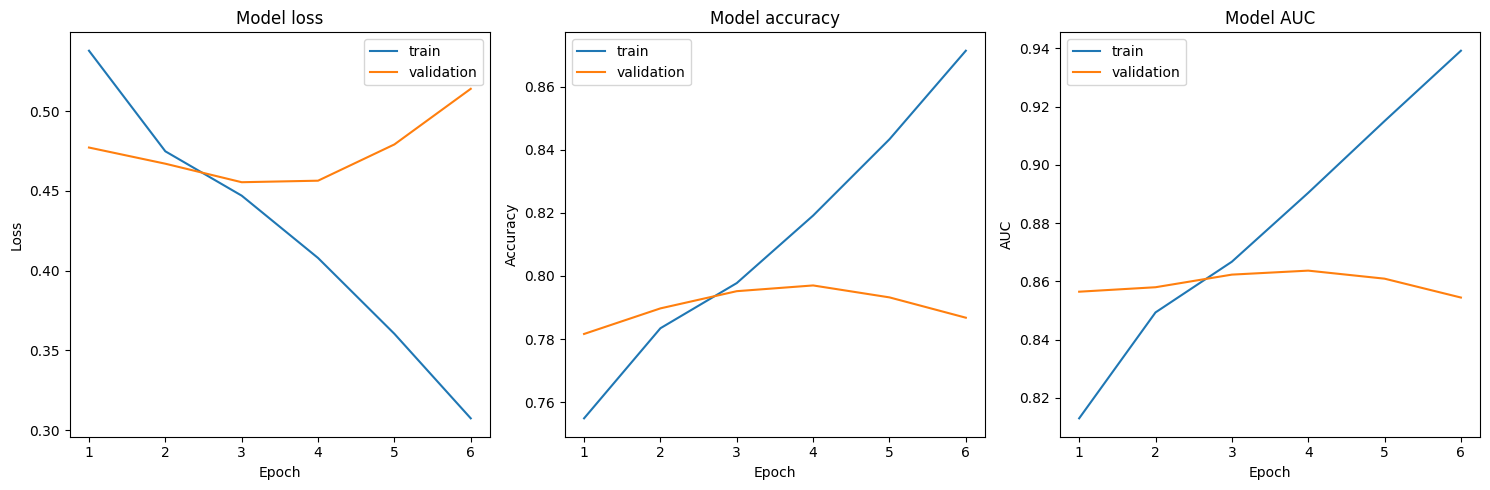

In [41]:
plot_history(basicConvHistory)

In [42]:
generate_output_csv_file(basicConvModel, test_generator, "basicConv.csv")

   4/3592 ━━━━━━━━━━━━━━━━━━━━ 3:59 67ms/step 

W0000 00:00:1712004850.539329      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3591/3592 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

2024-04-01 21:00:18.171741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8876: 6.96857, expected 6.16795
2024-04-01 21:00:18.171796: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8897: 6.74054, expected 5.93991
2024-04-01 21:00:18.171806: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8898: 6.33445, expected 5.53383
2024-04-01 21:00:18.171814: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8899: 6.57091, expected 5.77029
2024-04-01 21:00:18.171821: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8900: 6.60094, expected 5.80031
2024-04-01 21:00:18.171829: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8909: 6.56957, expected 5.76894
2024-04-01 21:00:18.171837: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8919: 6.45358, expected 5.65296
2024-04-01 21:00:18.171844: E exte

3592/3592 ━━━━━━━━━━━━━━━━━━━━ 368s 103ms/step


W0000 00:00:1712005218.675461      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [44]:
results_df = pd.DataFrame(columns=["Model Name", "Validation Loss", "Validation Accuracy", "Validation AUC", "Test score"])

In [ ]:
basicConvModel = create_basic_conv_model()
basicConvHistory = train_model(basicConvModel, train_gen, validation_gen, test_generator, numEpochs = 6)
modelMetrics = get_best_metrics(basicConvHistory)
print(f"Best Epoch: {modelMetrics[0]}")
print(f"Best Model Loss: {modelMetrics[1]}")
print(f"Best Model Accuracy: {modelMetrics[2]}")
print(f"Best Model AUC: {modelMetrics[3]}")
plot_history(basicConvHistory)
generate_output_csv_file(basicConvModel, test_generator, "basicConv.csv")

In [45]:
basicConv_testScore = 0.76
results_df.loc[len(results_df.index)] = ["Basic Conv, 30% training", modelMetrics[1], modelMetrics[2], modelMetrics[3], basicConv_testScore]

In [54]:
intermediateConvModel = create_intermediate_conv_model()
intrmdConvHistory = train_model(intermediateConvModel, train_gen, validation_gen, test_generator, numEpochs = 6)
modelMetrics = get_best_metrics(intrmdConvHistory)
print(f"Best Epoch: {modelMetrics[0]}")
print(f"Best Model Loss: {modelMetrics[1]}")
print(f"Best Model Accuracy: {modelMetrics[2]}")
print(f"Best Model AUC: {modelMetrics[3]}")
generate_output_csv_file(intermediateConvModel, test_generator, "intermediateConv.csv")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,483,233 (17.10 MB)

 Trainable params: 4,482,785 (17.10 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/6
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 108s 30ms/step - AUC: 0.7584 - accuracy: 0.7264 - loss: 1.1494 - val_AUC: 0.8738 - val_accuracy: 0.8069 - val_loss: 0.4381
Epoch 2/6
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 91s 28ms/step - AUC: 0.8542 - accuracy: 0.7974 - loss: 0.4734 - val_AUC: 0.7887 - val_accuracy: 0.5920 - val_loss: 1.1631
Epoch 3/6
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 92s 28ms/step - AUC: 0.8777 - accuracy: 0.8072 - loss: 0.4371 - val_AUC: 0.8646 - val_accuracy: 0.6392 - val_loss: 0.9562
Epoch 4/6
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 91s 28ms/step - AUC: 0.8903 - accuracy: 0.8190 - loss: 0.4188 - val_AUC: 0.8400 - val_accuracy: 0.6703 - val_loss: 0.9581
Epoch 4: early stopping
Best Epoch: 1
Best Model Loss: 0.43810221552848816
Best Model Accuracy: 0.8069085478782654
Best Model AUC: 0.8737571835517883
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 132s 37ms/step


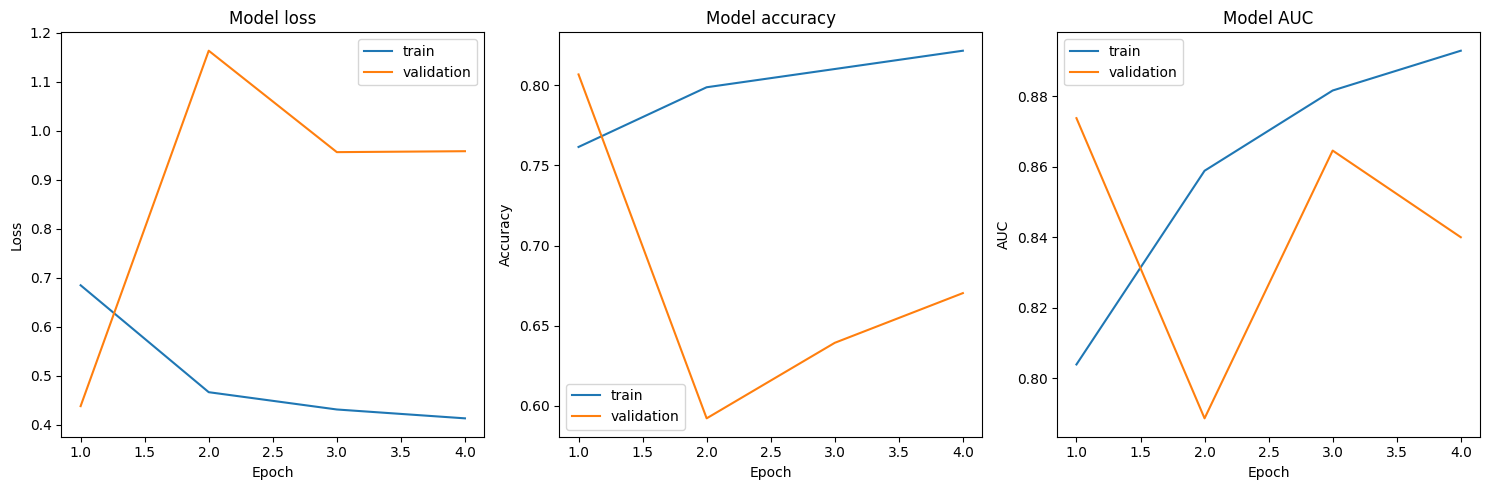

In [75]:
plot_history(intrmdConvHistory)

In [55]:
intConv_testScore = 0.70
results_df.loc[len(results_df.index)] = ["Intermediate Conv, 30% training", modelMetrics[1], modelMetrics[2], modelMetrics[3], intConv_testScore]

In [62]:
intermediateConvModel_SlowLR = create_intermediate_conv_model(LR = 0.0001)
intrmdConvHistory_SlowLR = train_model(intermediateConvModel_SlowLR, train_gen, validation_gen, test_generator, numEpochs = 12)
modelMetrics = get_best_metrics(intrmdConvHistory_SlowLR)
print(f"Best Epoch: {modelMetrics[0]}")
print(f"Best Model Loss: {modelMetrics[1]}")
print(f"Best Model Accuracy: {modelMetrics[2]}")
print(f"Best Model AUC: {modelMetrics[3]}")
generate_output_csv_file(intermediateConvModel_SlowLR, test_generator, "intermediateConv_SlowLR.csv")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,483,233 (17.10 MB)

 Trainable params: 4,482,785 (17.10 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/12
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 103s 29ms/step - AUC: 0.8130 - accuracy: 0.7563 - loss: 0.5727 - val_AUC: 0.8678 - val_accuracy: 0.7569 - val_loss: 0.5110
Epoch 2/12
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 92s 28ms/step - AUC: 0.8841 - accuracy: 0.8132 - loss: 0.4214 - val_AUC: 0.9095 - val_accuracy: 0.7996 - val_loss: 0.4488
Epoch 3/12
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 93s 28ms/step - AUC: 0.9050 - accuracy: 0.8341 - loss: 0.3836 - val_AUC: 0.9219 - val_accuracy: 0.8492 - val_loss: 0.3575
Epoch 4/12
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 92s 28ms/step - AUC: 0.9192 - accuracy: 0.8497 - loss: 0.3534 - val_AUC: 0.9188 - val_accuracy: 0.8397 - val_loss: 0.3873
Epoch 5/12
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 93s 28ms/step - AUC: 0.9349 - accuracy: 0.8644 - loss: 0.3182 - val_AUC: 0.9358 - val_accuracy: 0.8569 - val_loss: 0.3436
Epoch 6/12
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - AUC: 0.9454 - accuracy: 0.8791 - loss: 0.2914 - val_AUC: 0.9148 - val_accuracy: 0.6939 - val_loss: 0.7227
Epoch 7/12
330

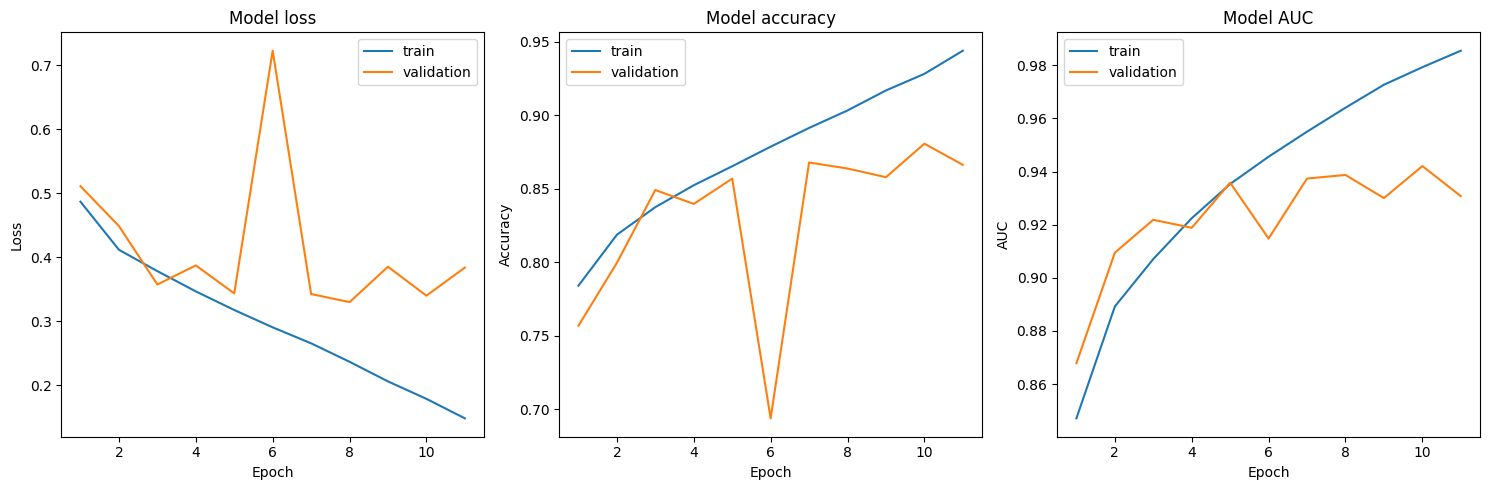

In [76]:
plot_history(intrmdConvHistory_SlowLR)

In [56]:
intConv_SlowLR_testScore = 0.82
results_df.loc[len(results_df.index)] = ["Int Conv, 30% training, SlowLR", modelMetrics[1], modelMetrics[2], modelMetrics[3], intConv_SlowLR_testScore]

In [72]:
advancedConvModel = create_advanced_conv_model(LR = 0.0001)
advancedConvHistory = train_model(advancedConvModel, train_gen, validation_gen, test_generator, numEpochs = 14)
modelMetrics = get_best_metrics(advancedConvHistory)
print(f"Best Epoch: {modelMetrics[0]}")
print(f"Best Model Loss: {modelMetrics[1]}")
print(f"Best Model Accuracy: {modelMetrics[2]}")
print(f"Best Model AUC: {modelMetrics[3]}")
generate_output_csv_file(advancedConvModel, test_generator, "advancedConv_30percent.csv")

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 92, 92, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,811,617 (14.54 MB)

 Trainable params: 3,811,169 (14.54 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/14
   7/3301 ━━━━━━━━━━━━━━━━━━━━ 1:11 22ms/step - AUC: 0.6655 - accuracy: 0.7055 - loss: 0.6971

W0000 00:00:1712009024.801586      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3297/3301 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - AUC: 0.8197 - accuracy: 0.7632 - loss: 0.5190

W0000 00:00:1712009107.176720      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3301/3301 ━━━━━━━━━━━━━━━━━━━━ 109s 30ms/step - AUC: 0.8197 - accuracy: 0.7632 - loss: 0.5190 - val_AUC: 0.8564 - val_accuracy: 0.7612 - val_loss: 0.4885
Epoch 2/14
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 93s 28ms/step - AUC: 0.8711 - accuracy: 0.8087 - loss: 0.4407 - val_AUC: 0.8600 - val_accuracy: 0.7962 - val_loss: 0.4821
Epoch 3/14
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 92s 28ms/step - AUC: 0.8923 - accuracy: 0.8254 - loss: 0.4055 - val_AUC: 0.9136 - val_accuracy: 0.8353 - val_loss: 0.3731
Epoch 4/14
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 93s 28ms/step - AUC: 0.9073 - accuracy: 0.8390 - loss: 0.3786 - val_AUC: 0.9171 - val_accuracy: 0.8368 - val_loss: 0.3686
Epoch 5/14
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 93s 28ms/step - AUC: 0.9211 - accuracy: 0.8529 - loss: 0.3503 - val_AUC: 0.9166 - val_accuracy: 0.8081 - val_loss: 0.4456
Epoch 6/14
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 93s 28ms/step - AUC: 0.9326 - accuracy: 0.8647 - loss: 0.3239 - val_AUC: 0.9314 - val_accuracy: 0.8636 - val_loss: 0.3336
Epoch 7/14
3301/3301 ━━━━━

W0000 00:00:1712010058.415708      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3592/3592 ━━━━━━━━━━━━━━━━━━━━ 133s 37ms/step


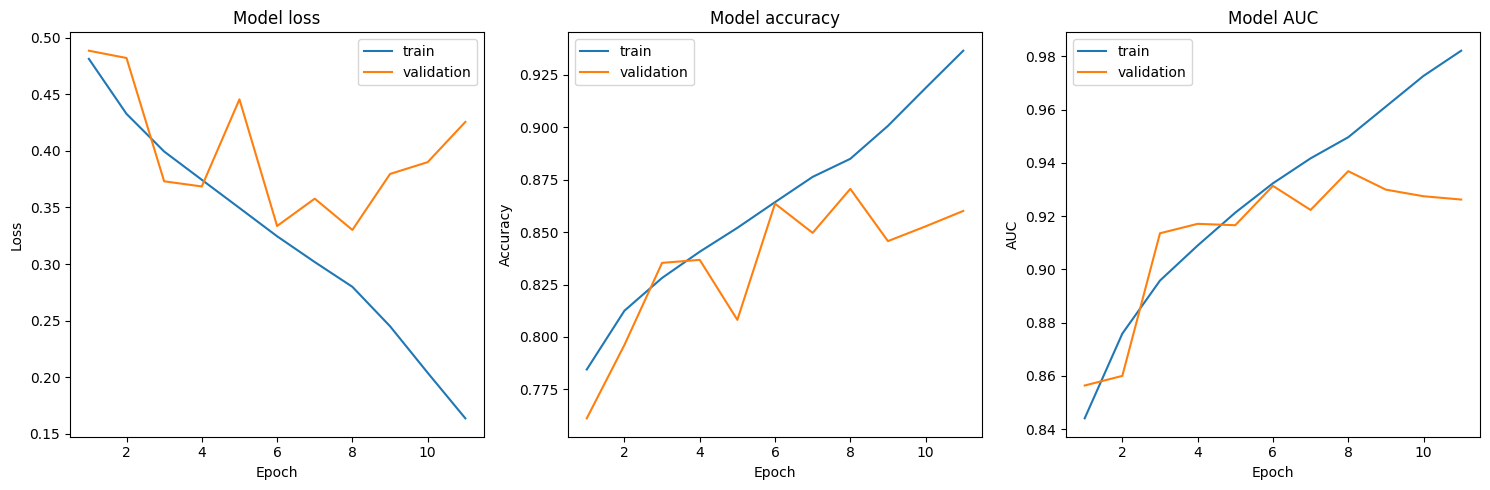

In [77]:
plot_history(advancedConvHistory)

In [73]:
advConv_testScore = 0.79
results_df.loc[len(results_df.index)] = ["Advanced Conv, 30% training, Slow LR", modelMetrics[1], modelMetrics[2], modelMetrics[3], advConv_testScore]

# Results and Conclusion
The intermediate complexity model had the best performance with a test score of 0.82.  This model has three blocks of convolutional layers followed by a batch normalization and max pooling, plus two fully connected layers along with a dropout layer.  This model had significantly better performance with the slow learning rate of 0.0001.

In [78]:
results_df

,Model Name,Validation Loss,Validation Accuracy,Validation AUC,Test score
0,"Basic Conv, 30% training",0.455481,0.795167,0.862331,0.76
1,"Intermediate Conv, 30% training",0.438102,0.806909,0.873757,0.70
2,"Int Conv, 30% training, SlowLR",0.438102,0.806909,0.873757,0.82
3,"Advanced Conv, 30% training, Slow LR",0.330154,0.870616,0.936870,0.79


**Additional insights:**
* Looking through the plots of validation accuracy, AUC, and loss shows a lot of of variation occuring across the epochs.  The intermediate model with slow learning rate appears to have the least variation apart from the significant excursion at epoch #6.  
* These results were obtained from using only 30% of the training data.  Use of more of the data may improve the results but could also start to lead to overfitting.
* The reduction in learning rate led to a significant improvement in performance.
* The "advanced" model had significantly better validation set performance but its test score was slightly worse than the third model.

## Further potential work
* It would be interesting to see the performance with 60% to 70% of the training data.
* The ImageDataGenerator has many options for manipulating the input images such as shifting, zooming, and flipping.  It would be interesting to see how these affect the results.